# Training with EfficientNet CNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from alive_progress import alive_bar
import time
import os
import glob
import pathlib
import shutil
import warnings
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation,
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import Callback
import seaborn as sns; sns.set()
#from alive_progress import alive_bar
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam, Adamax
from collections import Counter
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, f1_score, precision_score, \
                            recall_score, accuracy_score, classification_report

SEED=123
np.random.seed(SEED)

2023-07-30 23:47:26.171176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 23:47:26.882841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
input_malignant_train = "/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin/train/malin"
input_benign_train = "/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin/train/benin"

In [3]:
mal_list = os.listdir(input_malignant_train)
ben_list = os.listdir(input_benign_train)

In [4]:
df_mal = pd.DataFrame(mal_list)
df_mal.columns = ['image_id']
df_mal["dx"] = 'malignant'
df_ben = pd.DataFrame(ben_list)
df_ben.columns = ['image_id']
df_ben["dx"] = 'benign'

In [5]:
df_mal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1653 entries, 0 to 1652
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1653 non-null   object
 1   dx        1653 non-null   object
dtypes: object(2)
memory usage: 26.0+ KB


In [6]:
df_ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15372 entries, 0 to 15371
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  15372 non-null  object
 1   dx        15372 non-null  object
dtypes: object(2)
memory usage: 240.3+ KB


In [7]:
#testset (mal)
from sklearn.model_selection import StratifiedShuffleSplit

splitter=StratifiedShuffleSplit(n_splits=3,random_state=42)

for train,test in splitter.split(df_mal["image_id"], df_mal["dx"]):
    X_train_mal = df_mal["image_id"].iloc[train]
    y_train_mal = df_mal["dx"].iloc[train]
    X_test_mal = df_mal["image_id"].iloc[test]
    y_test_mal = df_mal["dx"].iloc[test]

In [8]:
train_mal = pd.concat([X_train_mal, y_train_mal], axis=1)
test_mal = pd.concat([X_test_mal, y_test_mal], axis=1)

In [9]:
train_mal

,image_id,dx
1410,ISIC_2844539_verticalFlip.jpg,malignant
665,ISIC_1785627_Rotation.jpg,malignant
1023,ISIC_3436033_rotate90.jpg,malignant
693,ISIC_0953317.jpg,malignant
908,ISIC_1684127_rotate90.jpg,malignant
...,...,...
1616,ISIC_1162337_verticalFlip.jpg,malignant
487,ISIC_6348638_rotate90.jpg,malignant
931,ISIC_5867911_flip.jpg,malignant
1339,ISIC_7293518_verticalFlip.jpg,malignant


In [10]:
#testset (ben)
from sklearn.model_selection import StratifiedShuffleSplit

splitter=StratifiedShuffleSplit(n_splits=3,random_state=42)

for train,test in splitter.split(df_ben["image_id"], df_ben["dx"]):
    X_train_ben = df_ben["image_id"].iloc[train]
    y_train_ben = df_ben["dx"].iloc[train]
    X_test_ben = df_ben["image_id"].iloc[test]
    y_test_ben = df_ben["dx"].iloc[test]

In [11]:
train_ben = pd.concat([X_train_ben, y_train_ben], axis=1)
test_ben = pd.concat([X_test_ben, y_test_ben], axis=1)

In [12]:
train_ben

,image_id,dx
10193,ISIC_4876193.jpg,benign
2005,ISIC_3558953.jpg,benign
1418,ISIC_0232963.jpg,benign
14986,ISIC_8550170.jpg,benign
8113,ISIC_1574020.jpg,benign
...,...,...
12100,ISIC_8900730.jpg,benign
2294,ISIC_5555140.jpg,benign
3374,ISIC_7542127.jpg,benign
14401,ISIC_8078589.jpg,benign


In [13]:
data_set_path = "/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin"

train_set_path_mal = "/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin/train/malin"

test_set_path_mal = "/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin/test/malin"

train_set_path_ben = "/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin/train/benin"

test_set_path_ben = "/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin/test/benin"


In [14]:
#Create testset (mal)
i = 0
total = len(test_mal)
with alive_bar(total, dual_line=True, force_tty=True) as bar:
    for _ in range(total):
        shutil.move(train_set_path_mal+'/'+test_mal.iloc[i][0], test_set_path_mal+'/'+test_mal.iloc[i][0])
        bar()
        i+=1

|████████████████████████████████████████| 166/166 [100%] in 0.1s (1621.97/s) 


In [15]:
#Create testset (ben)
i = 0
total = len(test_ben)
with alive_bar(total, dual_line=True, force_tty=True) as bar:
    for _ in range(total):
        shutil.move(train_set_path_ben+'/'+test_ben.iloc[i][0], test_set_path_ben+'/'+test_ben.iloc[i][0])
        bar()
        i+=1

|████████████████████████████████████████| 1538/1538 [100%] in 0.2s (11379.55/s)


In [16]:
CFG = dict(
        batch_size        =  4,     # 8; 16; 32; 64; bigger batch size => moemry allocation issue
        epochs            =  100,   # 5; 10; 20;
        verbose           =   1,    # 0; 1
        workers           =   4,    # 1; 2; 3

        optimizer         = 'adam', # 'SGD', 'RMSprop'

        RANDOM_STATE      =  123,

        # Path to save a model
        path_model        = '../working/',

        # Images sizes
        img_size          = 224,
        img_height        = 224,
        img_width         = 224,

        # Images augs
        ROTATION          = 180.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  [0.9,1.1],
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  10.0,
        WSHIFT            =  10.0,
        SHEAR             =   5.0,
        HFLIP             = True,
        VFLIP             = True,

        # Postprocessing
        label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;
)

In [17]:
class_labels = ['benign', 'malignant']

In [18]:
train_dir = pathlib.Path("/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin/train")
test_dir  = pathlib.Path("/root/Eve_Projet_Melanome/images/set_path/images_segment/benin_malin/test")

In [19]:
# Count number of images in each set.
img_count_train = len(list(train_dir.glob('*/*.jpg')))
img_count_test  = len(list(test_dir.glob('*/*.jpg')))
print('{} train images'.format(img_count_train))
print('{} test  images'.format(img_count_test))

15321 train images
20141 test  images


Found 15321 files belonging to 2 classes.
Using 12257 files for training.


2023-07-30 23:48:31.116430: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 15321 files belonging to 2 classes.
Using 3064 files for validation.
Found 20141 files belonging to 2 classes.

2 classes:
['benin', 'malin']


2023-07-30 23:48:32.045078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12257]
	 [[{{node Placeholder/_4}}]]
2023-07-30 23:48:32.045371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12257]
	 [[{{node Placeholder/_4}}]]


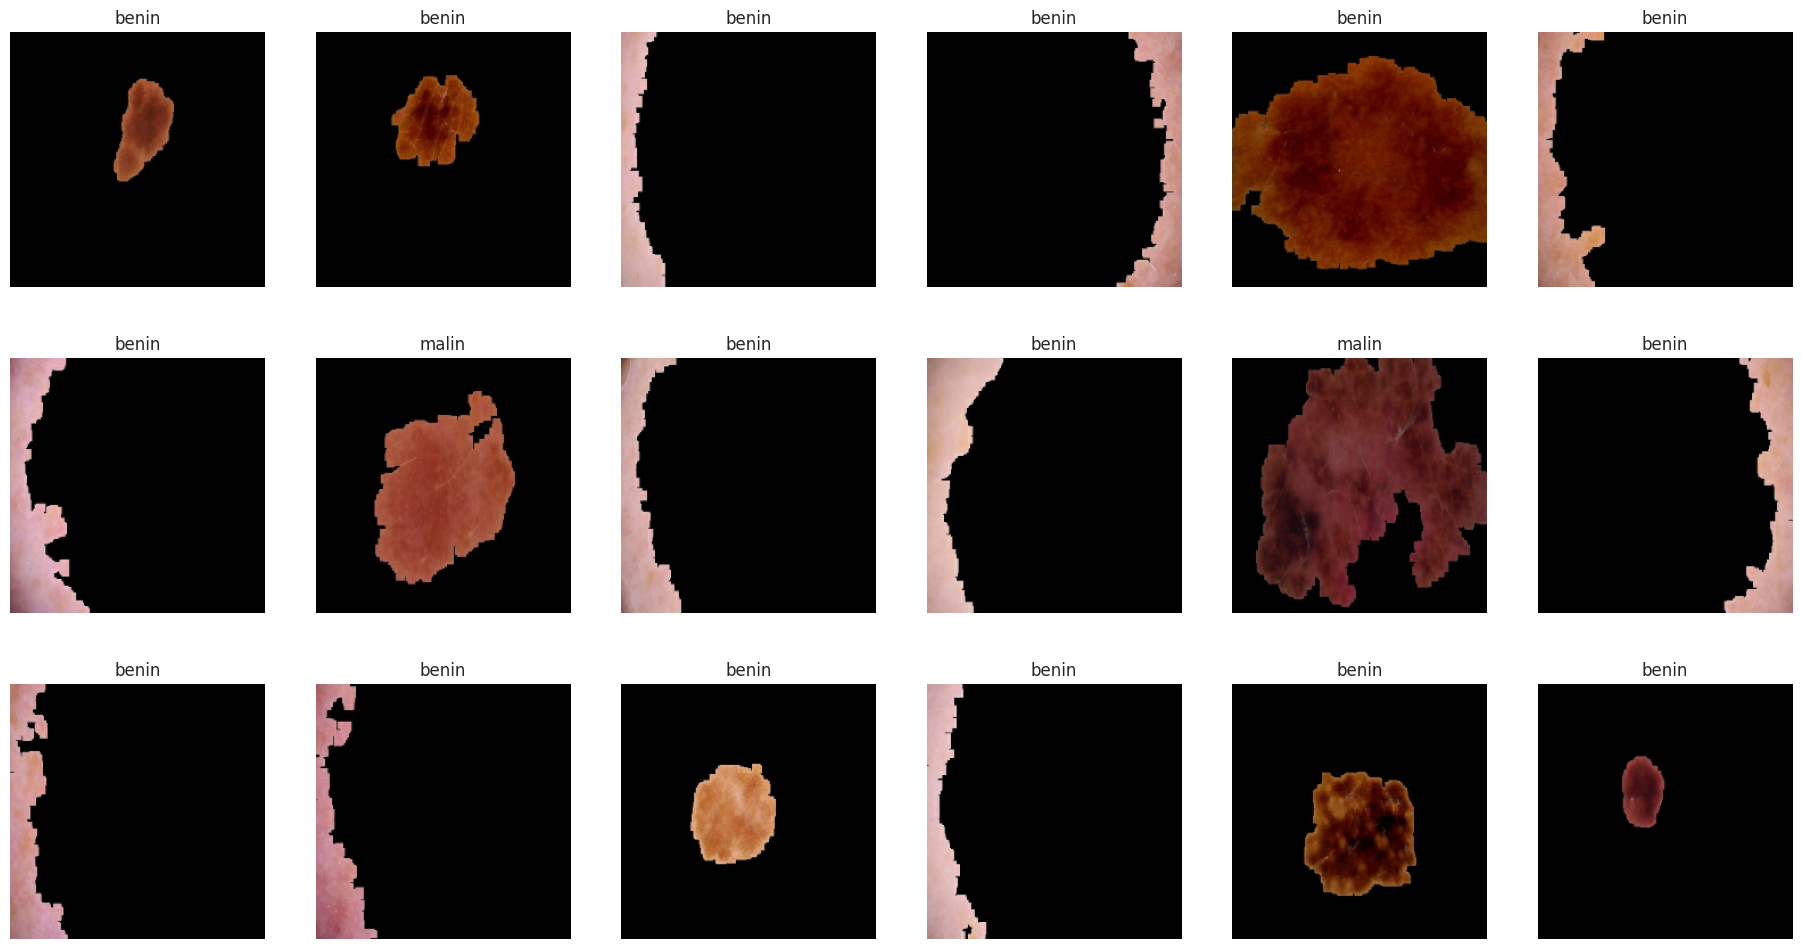

In [20]:
# We can read train and validation sets from same directory using Keras.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=0.2, image_size=(224,224), subset="training", seed=SEED)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=0.2, image_size=(224,224), subset="validation",seed=SEED)
test_ds  = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(224,224), seed=SEED)

class_names = train_ds.class_names
num_classes = len(class_names)
print('\n{} classes:\n{}'.format(num_classes,class_names))

plt.figure(figsize=(23, 12))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Preprocessing for keras

In [21]:
# Check data processing flow from directory
# Check data augmentation

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
    rotation_range            = CFG['ROTATION'],
    zoom_range                = CFG['ZOOM_RANGE'],
    horizontal_flip           = CFG['HFLIP'],
    vertical_flip             = CFG['VFLIP'],
    height_shift_range        = CFG['HSHIFT'],
    width_shift_range         = CFG['WSHIFT'],
    shear_range               = CFG['SHEAR'],
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test


# Train data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    subset='training',                  # to read train/valid from same directory
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator = valid_generator.flow_from_directory(train_dir,
                                                     subset='validation',               # to read train/valid from same directory
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = CFG['batch_size'],
                                                     class_mode='categorical'
                                                     )
# Test data
test_generator  = test_generator.flow_from_directory(test_dir,
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = 1,                    # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode='categorical'
                                                     )

Found 12258 images belonging to 2 classes.
Found 3063 images belonging to 2 classes.
Found 20141 images belonging to 2 classes.


In [22]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [23]:
# Class weights
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = np.unique(train_generator.classes),
                                     y = train_generator.classes)

unique_class_weights = np.unique(train_generator.classes)
class_weights_dict   = { unique_class_weights[i]: w for i,w in enumerate(class_weights) }

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator.classes))
print(train_generator.classes)
print(unique_class_weights)
print(Counter(train_generator.classes).keys())   # equals to list(set(x))
print(Counter(train_generator.classes).values()) # counts the elements' frequency


CLASS WEIGHTS: [0.55375858 5.15042017]

[0 1]
[0 0 0 ... 1 1 1]
[0 1]
dict_keys([0, 1])
dict_values([11068, 1190])


In [37]:
model_name='EfficientNetB7.h5'
base_model=tf.keras.applications.EfficientNetB7(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(2, activation='softmax')(x)
model_EffNet=Model(inputs=base_model.input, outputs=output)
model_EffNet.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model_EffNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [26]:
class Metrics(Callback):

    def __init__(self, valid_generator=None):
        self.X_test, self.Y_test = None, None
        self.valid_iterator = valid_generator

    def on_train_begin(self, logs={}):
        self.accuracy = []
        self.f1_scores = []
        self.recalls = []
        self.precisions = []

    def on_epoch_end(self, epoch, logs={}):
        self.X_test, self.Y_test = self.valid_iterator.next()
        pred = (np.asarray(self.model.predict(self.X_test))).round()
        predicted_label = np.argmax(pred, axis=1)

        target = self.Y_test
        target_label = np.argmax(target, axis=1)

        val_accuracy = accuracy_score(target_label, predicted_label)
        val_f1 = f1_score(target_label, predicted_label, average='weighted')
        val_recall = recall_score(target_label, predicted_label, average='weighted')
        val_precision = precision_score(target_label, predicted_label, average='weighted')

        self.accuracy.append(val_accuracy)
        self.f1_scores.append(val_f1)
        self.recalls.append(val_recall)
        self.precisions.append(val_precision)

        #print(confusion_matrix(target_label, predicted_label))
        #print(classification_report(target_label, predicted_label))

        print("Validation:")
        print("acc: {a:.2f} - f1-score: {f1:.2f} - prec: {p:.2f} - recall {r:.2f}"
              .format(a=val_accuracy, f1=val_f1, p=val_precision, r=val_recall))

In [27]:
def plot_history(history, metrics):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    # plot loss for each epoch
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.3f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot accuracy for each epoch
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.3f'))+')')

    plt.plot(epochs, metrics.accuracy, 'r', label='Validation Accuracy (' + str(format(np.mean(metrics.accuracy),'.3f'))+')')

    plt.title('Accuracy Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plot all mean performance metrics (accuracy, precision, recall and F1-score) for each epoch
    plt.figure(3)
    plt.plot(epochs, metrics.accuracy, 'r', label='Accuracy (' + str(format(np.mean(metrics.accuracy),'.3f'))+')')
    plt.plot(epochs, metrics.precisions, 'g', label='Precision (' + str(format(np.mean(metrics.precisions),'.3f'))+')')
    plt.plot(epochs, metrics.recalls, 'b', label='Recall (' + str(format(np.mean(metrics.recalls),'.3f'))+')')
    plt.plot(epochs, metrics.f1_scores, 'y', label='F1-score (' + str(format(np.mean(metrics.f1_scores),'.3f'))+')')

    plt.title('Validation set performances')
    plt.xlabel('Epochs')
    plt.ylabel('Performance metric')
    plt.legend()

    plt.show();

In [28]:
def plot_confusion_matrix(true_labels, predicted_labels, class_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure()
    plt.title('Confusion matrix')
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=sorted(class_labels), yticklabels=sorted(class_labels))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()
    plt.show();

In [29]:
metrics = Metrics(valid_generator)

In [ ]:
# train the resnet CNN

# create a Metrics instance for validation


history = model_EffNet.fit(train_generator,  epochs=20, verbose=1, callbacks=[metrics],  validation_data=valid_generator,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

weights_filename = "/root/Eve_Projet_Melanome/Meilleurs Poids/efficientnet_weights_melanoma.h5"
model_EffNet.save(weights_filename)
print('\nModel weights saved successfully on file {name}\n'.format(name=weights_filename))
# Définir le chemin du fichier de sauvegarde
save_path = "/root/Eve_Projet_Melanome/Modeles/model_EffNet.h5"

# Enregistrer le modèle
model_EffNet.save(save_path)

print("Modèle enregistré avec succès.")


In [ ]:
model_EffNet

In [38]:

model_EffNet.load_weights('/root/Eve_Projet_Melanome/Meilleurs Poids/efficientnet_weights_melanoma.h5')#,custom_objects={'get_f1': get_f1})


ValueError: Layer count mismatch when loading weights from file. Model expected 440 layers, found 0 saved layers.

In [33]:


# print and plot mean values of performance metrics related to the Validation set
print('*** VALIDATION SET PERFORMANCE EVALUATION ***')
print('Mean accuracy: {:.3f}'.format(np.mean(metrics.accuracy)))
print('Mean precision: {:.3f}'.format(np.mean(metrics.precisions)))
print('Mean recall: {:.3f}'.format(np.mean(metrics.recalls)))
print('Mean f1-score: {:.3f}'.format(np.mean(metrics.f1_scores)))

plot_history(history, metrics)

# *** TEST SET PERFORMANCE EVALUATION ***
# get prediction on test data
y_pred = model_EffNet.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

# compute and plot performance metrics values for each class
accuracy = accuracy_score(test_generator.classes, y_pred)
val_f1 = f1_score(test_generator.classes, y_pred, average='weighted')
val_recall = recall_score(test_generator.classes, y_pred, average='weighted')
val_precision = precision_score(test_generator.classes, y_pred, average='weighted')

print('*** TEST SET PERFORMANCE EVALUATION - AlexNet CNN ***')
print('Accuracy: {:.3f}'.format(accuracy))
print('F1-score: {:.3f}'.format(val_f1))
print('Recall: {:.3f}'.format(val_recall))
print('Precision: {:.3f}'.format(val_precision))

# print classification report and plot confusion matrix
print('\nClassification Report')
print(classification_report(test_generator.classes, y_pred))

plot_confusion_matrix(test_generator.classes, y_pred, class_labels)

*** VALIDATION SET PERFORMANCE EVALUATION ***


AttributeError: 'Metrics' object has no attribute 'accuracy'